In [1]:
#Import necessary packages
import pandas as pd
import numpy as np
import re
import nltk
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import warnings
warnings.filterwarnings('ignore')

import keras
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten, Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers, metrics


import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
df_main = pd.read_csv('/data/home/konstantin.parfenov/fetch.csv', delimiter=',')

#Создадим пол-возраст в начале датафрейма
df_main.insert(loc=3, column='gender_age', value = df_main['gender'] + df_main['age'])

#Меняем категории на чисельные значения
df_main['gender'] = df_main['gender'].map({'F': 0, 'M': 1})
df_main['age'] = df_main['age'].map({'18-24': 0, '25-34': 2, '35-44': 3,'45-54': 4, '>=55': 5 })
df_main['gender_age'] = df_main['gender_age'].map({'F18-24': 0, F'25-34': 1, 'F35-44': 2,'F45-54': 3, 'F>=55': 4,'M18-24': 5, 'M25-34': 6, 'M35-44': 7,'M45-54': 8, 'M>=55': 9 })

#Укажем границу между классами+id и фичами сейчас это age, gender, genderage, uid итого 4
feature_border = 4

#отделяем тест от трейна
df_train = df_main.iloc[0:36138]
df_train.fillna(0, inplace = True)
df_test = df_main.iloc[36138:]
column_headers = list(df_test.columns.values)
df_test[column_headers[feature_border:]]
df_test[column_headers[feature_border:]]=df_test[column_headers[feature_border:]].fillna(value=0)

In [3]:
df_main['gender_age'].unique()

array([ 0.,  6., nan,  9.,  3.,  2.,  7.,  4.,  5.,  8.])

In [4]:
df_train.tail(10)

,gender,gender_age,age,uid,авто и мото прочее,авто и мото торговля,автотовары авто и мото,агрегаторы прочее,азартные игры ставки,бизнес новости и сми,...,услуги медицина,услуги перевозки,услуги прочее,услуги справочные ресурсы,услуги техника и технологии,услуги транспорт,финансы новости и сми,финансы прочее,финансы услуги,цветы торговля
36128,1.0,6.0,2.0,bd723a3c-4d87-49ae-be94-585905217995,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36129,0.0,3.0,4.0,bd72e63c-53b6-44fd-9366-e10cdae64951,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0
36130,0.0,0.0,2.0,bd72e796-3c60-4e80-84d8-40fae2c48ced,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,34.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
36131,1.0,6.0,2.0,bd743735-3307-43f1-9d69-6ceac5fe2111,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36132,0.0,2.0,3.0,bd760bb8-fcfa-4ec5-ae8f-b37f5bab72be,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36133,1.0,7.0,3.0,bd762af7-17cc-4309-be1b-357fce9e3d4b,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36134,1.0,6.0,2.0,bd78086e-4a6d-4e5b-b930-174f722ad661,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36135,1.0,6.0,2.0,bd783220-88f7-435b-a14d-6aeb07d7a53a,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36136,1.0,5.0,0.0,bd79a9fa-34d1-46b3-8cf1-ddacd0b730a5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36137,1.0,6.0,2.0,bd79ac4b-c0e8-405b-a972-f4e88f7efadc,0.0,0.0,0.0,20.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_test.head(10)

,gender,gender_age,age,uid,авто и мото прочее,авто и мото торговля,автотовары авто и мото,агрегаторы прочее,азартные игры ставки,бизнес новости и сми,...,услуги медицина,услуги перевозки,услуги прочее,услуги справочные ресурсы,услуги техника и технологии,услуги транспорт,финансы новости и сми,финансы прочее,финансы услуги,цветы торговля
36138,NaN,NaN,NaN,bd7a30e1-a25d-4cbf-a03f-61748cbe540e,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
36139,NaN,NaN,NaN,bd7a6f52-45db-49bf-90f2-a3b07a9b7bcd,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,29.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0
36140,NaN,NaN,NaN,bd7a7fd9-ab06-42f5-bf0f-1cbb0463004c,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36141,NaN,NaN,NaN,bd7c5d7a-0def-41d1-895f-fdb96c56c2d4,34.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36142,NaN,NaN,NaN,bd7e54a2-0215-45cb-a869-9efebf250e38,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36143,NaN,NaN,NaN,bd7e9797-4cdb-46e1-a540-f3ea010605ad,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36144,NaN,NaN,NaN,bd7e9ec7-fb67-45eb-8ad3-209d01d15ae6,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36145,NaN,NaN,NaN,bd8056df-cc25-4b63-bc12-a46f888baa49,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36146,NaN,NaN,NaN,bd818690-73d2-445d-be5d-5c8f748dbb19,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36147,NaN,NaN,NaN,bd81e006-f059-4cdd-b716-3467c78d1312,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#get column names
column_headers = list(df_train.columns.values)
features_len = len(column_headers[feature_border:])

Определение половой группы

In [7]:
X_train = df_train[column_headers[feature_border:]]
#X_train

In [8]:
y_train = df_train['gender']

In [9]:
#Бинарная классификация для пола
model = Sequential()

metrics = [
    'accuracy',

   
]
#Указываем кол-во столбцов
model.add(Dense(128, activation='relu', input_dim = features_len))

model.add(Dense(1, activation ='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=metrics)

Train on 28910 samples, validate on 7228 samples
Epoch 1/3
28910/28910 [==============================] - 9s 296us/step - loss: 0.9558 - acc: 0.5837 - val_loss: 0.8438 - val_acc: 0.5949
Epoch 2/3
28910/28910 [==============================] - 2s 65us/step - loss: 0.9018 - acc: 0.6003 - val_loss: 0.8995 - val_acc: 0.5625
Epoch 3/3
28910/28910 [==============================] - 2s 69us/step - loss: 0.8720 - acc: 0.6046 - val_loss: 0.9379 - val_acc: 0.5838


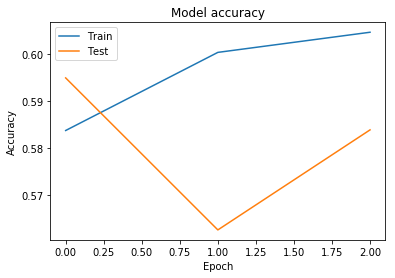

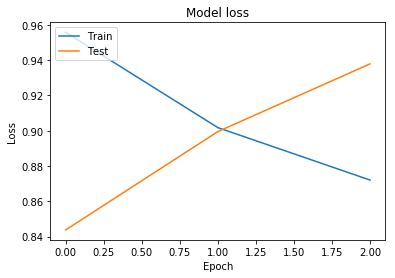

"\n# Plot training & validation loss values\nplt.plot(history.history['cosine_proximity'])\nplt.plot(history.history['val_cosine_proximity'])\nplt.title('Cosine_proximity')\nplt.ylabel('Loss')\nplt.xlabel('Epoch')\nplt.legend(['Train', 'Test'], loc='upper left')\nplt.show()\n"

In [10]:



batch_size = 64
epochs = 3
history = model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
'''
# Plot training & validation loss values
plt.plot(history.history['cosine_proximity'])
plt.plot(history.history['val_cosine_proximity'])
plt.title('Cosine_proximity')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
'''

Определение поло-возрастной группы

In [11]:
X_gender_age_train = df_train[column_headers[feature_border:]]
y_gender_age_train = df_train['gender_age']

In [12]:
# model 10 classes (categorical classification):
# 
# Convert labels to categorical one-hot encoding - Вариант создания категорий из текста
# one_hot_labels = keras.utils.to_categorical(labels, num_classes=5)

y_gender_age_train_mod = keras.utils.to_categorical(y_gender_age_train, num_classes=10)

#Для себя надо внимательно прочитать про loss='sparse_categorical_crossentropy' и альтернативы


model_gender_age = Sequential()
model_gender_age.add(Dense(128, activation='relu', input_dim=features_len)),
model_gender_age.add(Dense(32, activation="relu")),
model_gender_age.add(Dense(10, activation='sigmoid'))
model_gender_age.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy','categorical_accuracy','top_k_categorical_accuracy','cosine_proximity'])

Epoch 1/3
36138/36138 [==============================] - 1s 28us/step - loss: 2.2973 - acc: 0.2231 - categorical_accuracy: 0.2231 - top_k_categorical_accuracy: 0.7676 - cosine_proximity: -0.3403
Epoch 2/3
36138/36138 [==============================] - 0s 12us/step - loss: 2.1615 - acc: 0.2567 - categorical_accuracy: 0.2567 - top_k_categorical_accuracy: 0.8324 - cosine_proximity: -0.3616
Epoch 3/3
36138/36138 [==============================] - 0s 12us/step - loss: 2.1304 - acc: 0.2667 - categorical_accuracy: 0.2667 - top_k_categorical_accuracy: 0.8303 - cosine_proximity: -0.3668


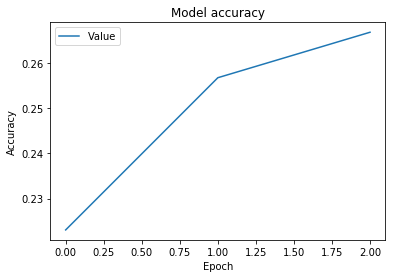

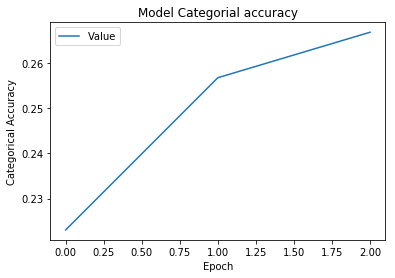

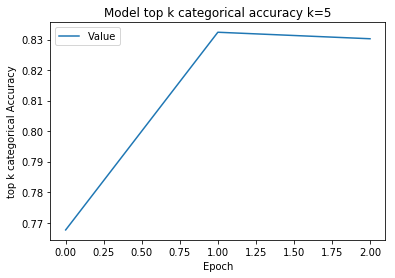

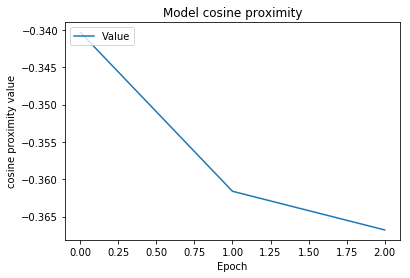

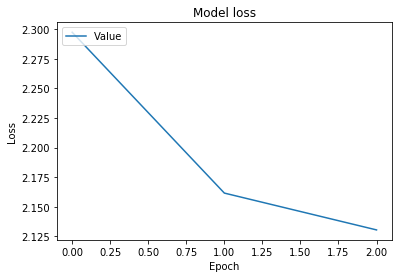

In [13]:

history_gender_age = model_gender_age.fit(X_gender_age_train, y_gender_age_train_mod, epochs=3, batch_size=512, verbose=1)

# Plot training & validation accuracy values
plt.plot(history_gender_age.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Value'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history_gender_age.history['categorical_accuracy'])
plt.title('Model Categorial accuracy')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.legend(['Value'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history_gender_age.history['top_k_categorical_accuracy'])
plt.title('Model top k categorical accuracy k=5')
plt.ylabel('top k categorical Accuracy')
plt.xlabel('Epoch')
plt.legend(['Value'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history_gender_age.history['cosine_proximity'])
plt.title('Model cosine proximity')
plt.ylabel('cosine proximity value')
plt.xlabel('Epoch')
plt.legend(['Value'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_gender_age.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Value'], loc='upper left')
plt.show()

In [14]:
model_gender_age.save("/data/home/konstantin.parfenov/model_gender_age.h5")

Создание предикта

In [15]:
X_test=df_test[column_headers[feature_border:]]
X_test

,авто и мото прочее,авто и мото торговля,автотовары авто и мото,агрегаторы прочее,азартные игры ставки,бизнес новости и сми,бизнес прочее,бизнес торговля,видео прочее,государство и общество прочее,...,услуги медицина,услуги перевозки,услуги прочее,услуги справочные ресурсы,услуги техника и технологии,услуги транспорт,финансы новости и сми,финансы прочее,финансы услуги,цветы торговля
36138,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
36139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,29.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0
36140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36141,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
Y_test=model_gender_age.predict_classes(X_test)
Y_test_proba=model_gender_age.predict(X_test)

In [17]:
dict_gender = {0:'F', 1:'F', 2:'F',3:'F', 4:'F', 5:'M', 6:'M', 7:'M', 8:'M', 9:'M'}
dict_age = {0:'18-24', 1:'25-34', 2:'35-44', 3:'45-54', 4:'>=55', 5:'18-24', 6:'25-34', 7:'35-44', 8:'45-54', 9:'>=55',}

gender_predict = pd.Series([dict_gender.get(n, n) for n in Y_test])
age_predict = pd.Series([dict_age.get(n, n) for n in Y_test])

print(gender_predict)
print(age_predict)

'''
import numpy as np
A = np.array(a)
maximum_indices = np.where(A==max(a))

gender_predict_alt=[dict_gender.get(n, n) for n in Y_test]
'''

0       F
1       F
2       F
3       M
4       F
5       F
6       F
7       M
8       F
9       F
10      F
11      F
12      F
13      F
14      F
15      F
16      F
17      F
18      F
19      M
20      M
21      F
22      F
23      M
24      F
25      F
26      M
27      F
28      F
29      F
       ..
4970    F
4971    F
4972    F
4973    F
4974    F
4975    M
4976    F
4977    F
4978    F
4979    M
4980    M
4981    F
4982    F
4983    F
4984    M
4985    F
4986    F
4987    F
4988    M
4989    M
4990    F
4991    F
4992    M
4993    F
4994    M
4995    F
4996    F
4997    F
4998    F
4999    M
Length: 5000, dtype: object
0       18-24
1       18-24
2       18-24
3       25-34
4       18-24
5       18-24
6       18-24
7       25-34
8       18-24
9       18-24
10      18-24
11      18-24
12      18-24
13      18-24
14      18-24
15      18-24
16      18-24
17      18-24
18      18-24
19      25-34
20      25-34
21      18-24
22      18-24
23      25-34
24      18-24
25      18-2

'\nimport numpy as np\nA = np.array(a)\nmaximum_indices = np.where(A==max(a))\n\ngender_predict_alt=[dict_gender.get(n, n) for n in Y_test]\n'

In [18]:
Y_test_proba[2]

array([0.613695  , 0.41289046, 0.5759884 , 0.51762766, 0.46947777,
       0.5446653 , 0.5608372 , 0.5507068 , 0.5005272 , 0.463219  ],
      dtype=float32)

In [19]:
# Get the maximum values of each row i.e. along axis 1
class_predict_proba = np.amax(Y_test_proba, axis=1)
print(class_predict_proba)
len(class_predict_proba)
class_predict_proba

[1.         1.         0.613695   ... 0.9533668  0.5853882  0.99998474]


array([1.        , 1.        , 0.613695  , ..., 0.9533668 , 0.5853882 ,
       0.99998474], dtype=float32)

In [20]:
result = np.where(Y_test_proba == np.amax(Y_test_proba))
print(result[0])

[   0    0    0 ... 4986 4996 4996]


создадим нефильтрованный предикт

In [21]:
df_prdiction=df_test['uid'].copy()


(np.argmax(Y_test_proba, axis=1))


array([0, 0, 0, ..., 0, 0, 6])

In [24]:
df_test

,gender,gender_age,age,uid,авто и мото прочее,авто и мото торговля,автотовары авто и мото,агрегаторы прочее,азартные игры ставки,бизнес новости и сми,...,услуги медицина,услуги перевозки,услуги прочее,услуги справочные ресурсы,услуги техника и технологии,услуги транспорт,финансы новости и сми,финансы прочее,финансы услуги,цветы торговля
36138,NaN,NaN,NaN,bd7a30e1-a25d-4cbf-a03f-61748cbe540e,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
36139,NaN,NaN,NaN,bd7a6f52-45db-49bf-90f2-a3b07a9b7bcd,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,29.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0
36140,NaN,NaN,NaN,bd7a7fd9-ab06-42f5-bf0f-1cbb0463004c,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36141,NaN,NaN,NaN,bd7c5d7a-0def-41d1-895f-fdb96c56c2d4,34.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36142,NaN,NaN,NaN,bd7e54a2-0215-45cb-a869-9efebf250e38,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36143,NaN,NaN,NaN,bd7e9797-4cdb-46e1-a540-f3ea010605ad,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36144,NaN,NaN,NaN,bd7e9ec7-fb67-45eb-8ad3-209d01d15ae6,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36145,NaN,NaN,NaN,bd8056df-cc25-4b63-bc12-a46f888baa49,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36146,NaN,NaN,NaN,bd818690-73d2-445d-be5d-5c8f748dbb19,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36147,NaN,NaN,NaN,bd81e006-f059-4cdd-b716-3467c78d1312,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
frame = { 'uid': df_test.iloc[:,3], 'age': age_predict, 'gender': gender_predict } 
output = pd.DataFrame(frame) 